In [1]:
import pandas as pd

# Load and clean the data
file_path = 'C://Users//ansankar//Downloads//Airbnb_Open_Data (2).csv'
df = pd.read_csv(file_path)
df['neighbourhood group'] = df['neighbourhood group'].replace({'brookln': 'Brooklyn', 'manhatan': 'Manhattan'})
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
df['review rate number'] = pd.to_numeric(df['review rate number'], errors='coerce')

# Filter out rows with  values in important columns, including price
df_cleaned = df.dropna(subset=['neighbourhood group', 'review rate number', 'number of reviews', 'lat', 'long', 'price'])

print("Data loaded and cleaned. Shape of cleaned data:", df_cleaned.shape)
print(df_cleaned.head())


Data loaded and cleaned. Shape of cleaned data: (101810, 26)
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... s

C:\Users\ansankar\AppData\Local\Temp\ipykernel_38936\1839782296.py:5: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [2]:
import sqlite3

# Create a new SQLite database (or connect to an existing one)
conn = sqlite3.connect('airbnb_listings.db')

# Create a new table for the listings
df_cleaned.to_sql('listings', conn, if_exists='replace', index=False)

# Verify that the table has been created and data inserted
query = "SELECT COUNT(*) FROM listings"
count = conn.execute(query).fetchone()[0]

print("SQLite database and table created.")
print("Number of records in the table:", count)

# Close the connection
conn.close()


SQLite database and table created.
Number of records in the table: 101810


Interactive Plotly map using SQLite data has been created and saved as 'nyc_airbnb_plotly_map_sqlite.html'.


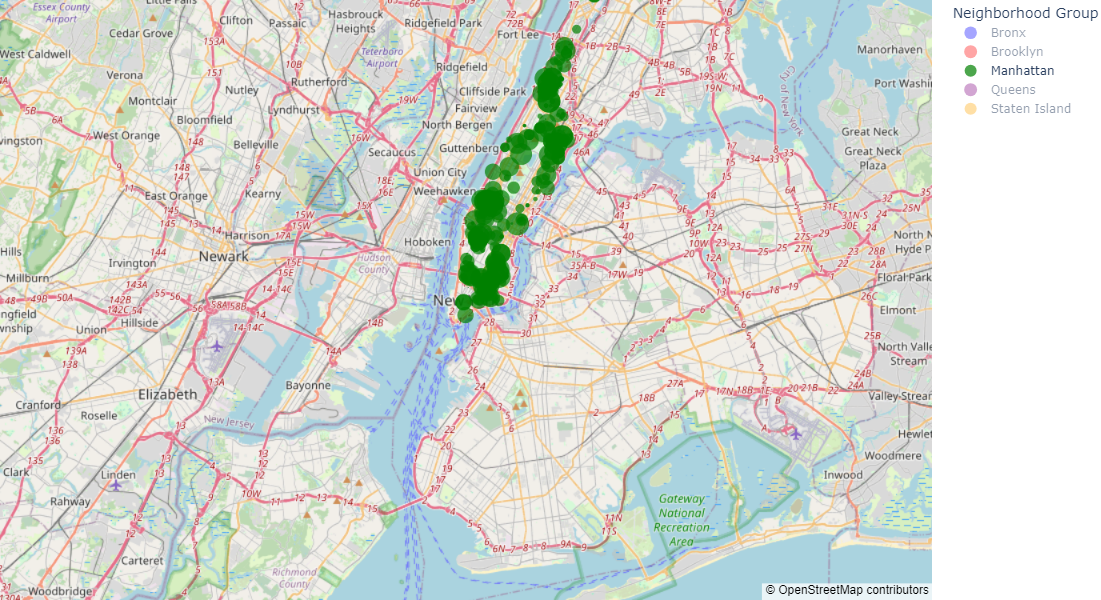

In [3]:
import plotly.graph_objects as go
import base64
import pandas as pd
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('airbnb_listings.db')

# Query to get top 300 listings per neighborhood group
query = """
SELECT *
FROM (
  SELECT *,
         ROW_NUMBER() OVER (PARTITION BY "neighbourhood group" ORDER BY "review rate number" DESC, "number of reviews" DESC) as rn
  FROM listings
)
WHERE rn <= 300
"""

# Execute the query and load results into a DataFrame
top_listings = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Create a figure with mapbox
fig = go.Figure()

# Define distinct colors for each neighborhood group
color_map = {
    'Bronx': 'blue',
    'Brooklyn': 'red',
    'Manhattan': 'green',
    'Queens': 'purple',
    'Staten Island': 'orange'
}

# Add traces for each neighborhood group
for group in top_listings['neighbourhood group'].unique():
    df_group = top_listings[top_listings['neighbourhood group'] == group]
    fig.add_trace(go.Scattermapbox(
        lat=df_group['lat'],
        lon=df_group['long'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=df_group['price'] / 50,
            color=color_map[group],
            opacity=0.7
        ),
        text=df_group['NAME'],
        hoverinfo='text',
        name=group,
        customdata=df_group[['price', 'neighbourhood', 'review rate number']],
        hovertemplate="<b>%{text}</b><br>" +
                      "Price: $%{customdata[0]:.2f}<br>" +
                      "Neighborhood: %{customdata[1]}<br>" +
                      "Review Rate: %{customdata[2]}<br>" +
                      "<extra></extra>"
    ))

# Update the layout
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(
        center=dict(lat=40.7128, lon=-74.0060),
        zoom=10
    ),
    showlegend=True,
    height=600,
    margin={"r":0,"t":0,"l":0,"b":0},
    legend_title_text='Neighborhood Group'
)

# Convert the figure to HTML
html_string = fig.to_html(full_html=False, include_plotlyjs='cdn')

# Encode the HTML string to base64
encoded_html = base64.b64encode(html_string.encode()).decode()

# Save the encoded HTML to a file
with open('nyc_airbnb_plotly_map_sqlite.html', 'w') as f:
    f.write(f'<iframe src="data:text/html;base64,{encoded_html}" width="100%" height="600"></iframe>')

print("Interactive Plotly map using SQLite data has been created and saved as 'nyc_airbnb_plotly_map_sqlite.html'.")
fig.show()